## Question 1

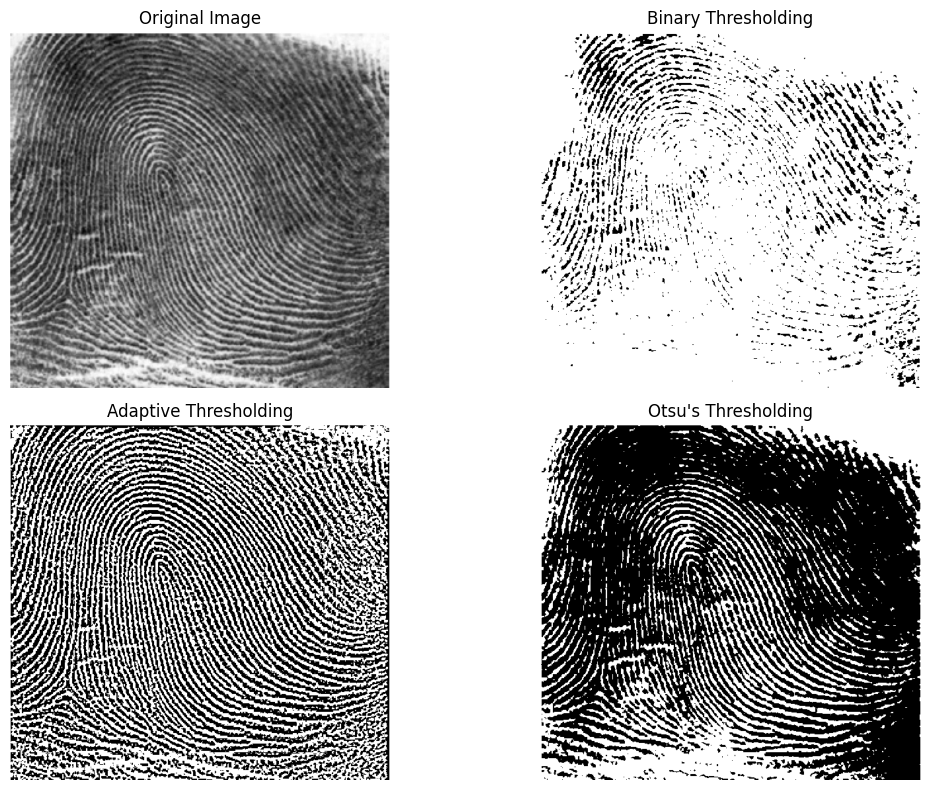

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the grayscale image
img = cv2.imread("./../images/fingerprint.png", cv2.IMREAD_GRAYSCALE)

# Ensure the image is loaded successfully
if img is None:
    raise FileNotFoundError("The image file './images/1.png' could not be loaded.")

# Apply Binary Thresholding
_, binary_thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Apply Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(
    img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
)

# Apply Otsu's Thresholding
_, otsu_thresh = cv2.threshold(img, 0, 255,  cv2.THRESH_OTSU)

# Display all images side by side
titles = ['Original Image', 'Binary Thresholding', 'Adaptive Thresholding', "Otsu's Thresholding"]
images = [img, binary_thresh, adaptive_thresh, otsu_thresh]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

# Save comparison image
plt.tight_layout()
# plt.savefig("./../output/segmentation_comparison.png")
# print("Comparison image saved as './output/segmentation_comparison.png'")


### Discussion on Best Segmentation Method

Binary Thresholding: Simple but loses fine details and struggles with uneven lighting, resulting in noisy output.\
Adaptive Thresholding: Handles lighting variations effectively, preserving fingerprint ridges with high clarity, though it may introduce minor noise.\
Otsu’s Thresholding: Automatically selects an optimal threshold but performs poorly under non-uniform lighting, losing some ridge clarity.


Best Method: Adaptive Thresholding.
Reason: It preserves fine details of the fingerprint ridges and effectively handles lighting variations, providing clearer boundaries compared to Binary Thresholding (loss of detail and noise) and Otsu's Thresholding (poor performance under uneven lighting).

## Question 2

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_lines(image_path, canny_threshold1, canny_threshold2, hough_threshold):
    """
    Detect and highlight straight lines in an image using the Hough Line Transform.
    
    Parameters:
    - image_path: str, path to the input image.
    - canny_threshold1, canny_threshold2: int, thresholds for the Canny edge detector.
    - hough_threshold: int, accumulator threshold parameter for Hough Transform.
    
    Returns:
    - original_img: Original image.
    - line_image: Image with detected lines drawn.
    """
    # Load the image in color
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"The image file '{image_path}' could not be loaded.")
    
    # Convert the image to grayscale for edge detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Preprocess the image using the Canny edge detector
    edges = cv2.Canny(gray, canny_threshold1, canny_threshold2)
    
    # Apply the Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, hough_threshold)
    
    # Create a copy of the original image to draw lines
    line_image = img.copy()
    
    # Draw the detected lines
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    return img, line_image

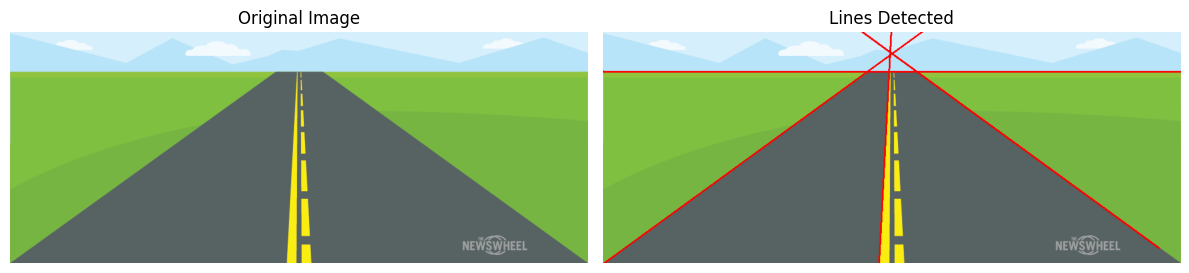

In [44]:


# Path to the image
image_path = "./../images/2.png"

# Detect lines with specified parameters
original_img, processed_img = detect_lines(image_path, 50, 150, 200)

# Convert images from BGR to RGB for Matplotlib visualization
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

# Display the original and processed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed_img_rgb)
plt.title('Lines Detected')
plt.axis('off')

# Save the results
output_path = "./../output/hough_transform_result.png"
plt.tight_layout()
# plt.savefig(output_path)
# print(f"Hough Transform result saved as '{output_path}'")



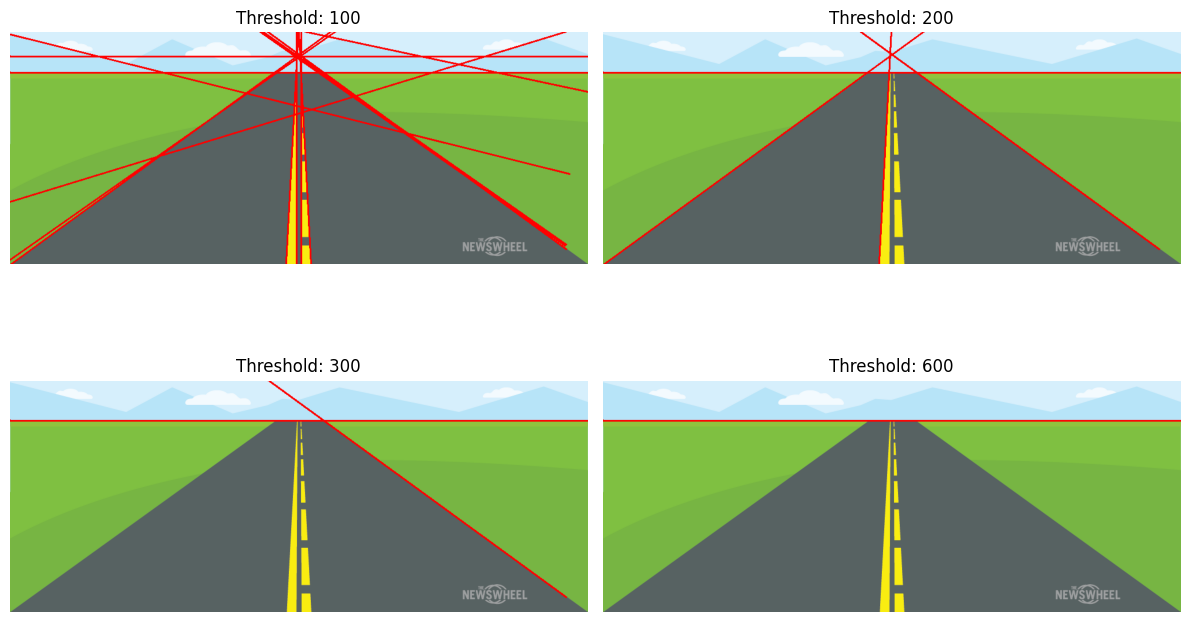

In [45]:
thresholds = [100, 200, 300, 600]

plt.figure(figsize=(12, 8))

for i, threshold in enumerate(thresholds):
    _, processed_img = detect_lines(image_path, 50, 150, threshold)  # Pass the single threshold value

    plt.subplot(2, 2, i + 1)
    plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Threshold: {threshold}")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Experimentation with Threshold Parameters in the Hough Transform:

As shown in the visualization:
1. **Threshold = 100**: A low threshold results in detecting many lines, including noise and overlapping redundant lines, which reduces clarity.
2. **Threshold = 200**: This strikes a balance, highlighting the primary road lines while filtering some irrelevant lines.
3. **Threshold = 300**: Further reduces line detections, focusing on the most prominent lines, but some critical lines might start disappearing.
4. **Threshold = 600**: High threshold values filter out nearly all noise, detecting only the most dominant lines, though subtle details may be lost.

### Conclusion:
The choice of the threshold should balance between highlighting key features and avoiding excessive noise. For this specific image, thresholds between 200–300 seem optimal.


## Question 3

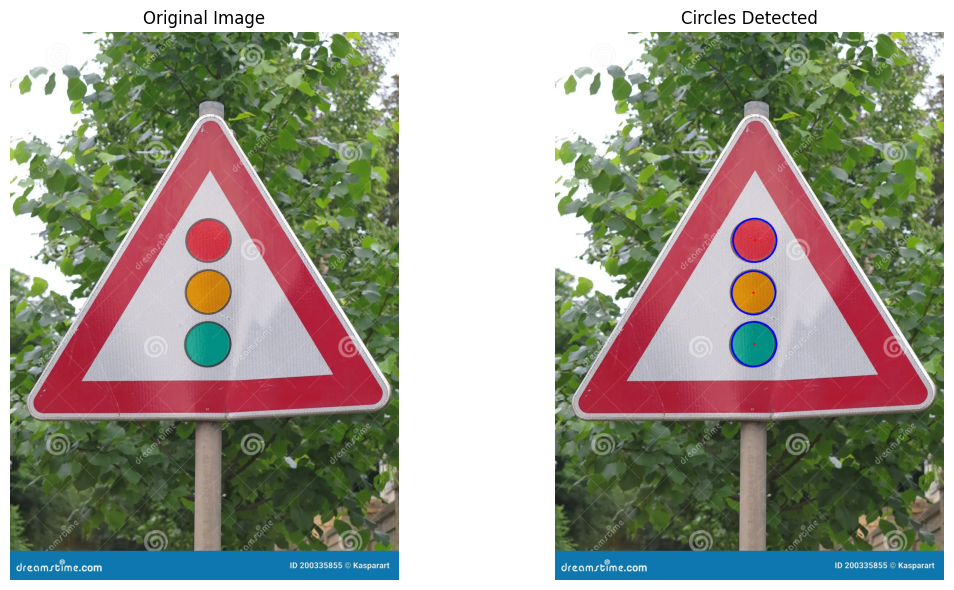

In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_circles(image_path, min_radius=60, max_radius=70, param1=50, param2=30):
    """
    Detect circles in an image using Hough Circle Transform
    """
    # Read image with explicit flag
    img = cv2.imread(image_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    
    # Convert to 8-bit if needed
    if img.dtype == np.uint32 or img.dtype == np.float32:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Handle multi-channel images
    if len(img.shape) > 2 and img.shape[2] > 3:
        img = img[:, :, :3]
    
    # Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        blurred, 
        cv2.HOUGH_GRADIENT, 
        dp=1, 
        minDist=70,
        param1=param1, 
        param2=param2, 
        minRadius=min_radius, 
        maxRadius=max_radius
    )
    
    # Draw detected circles
    result_img = img.copy()
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # Draw outer circle in blue with increased thickness
            cv2.circle(result_img, (i[0], i[1]), i[2], (255, 0, 0), 4)
            # Draw circle center in red
            cv2.circle(result_img, (i[0], i[1]), 2, (0, 0, 255), 3)
    
    return result_img

# Set image path relative to script
input_image_path = './../images/3.png'

# Detect circles
result_image = detect_circles(input_image_path)

# Display original and processed images
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(cv2.imread(input_image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(122)
plt.title('Circles Detected')
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


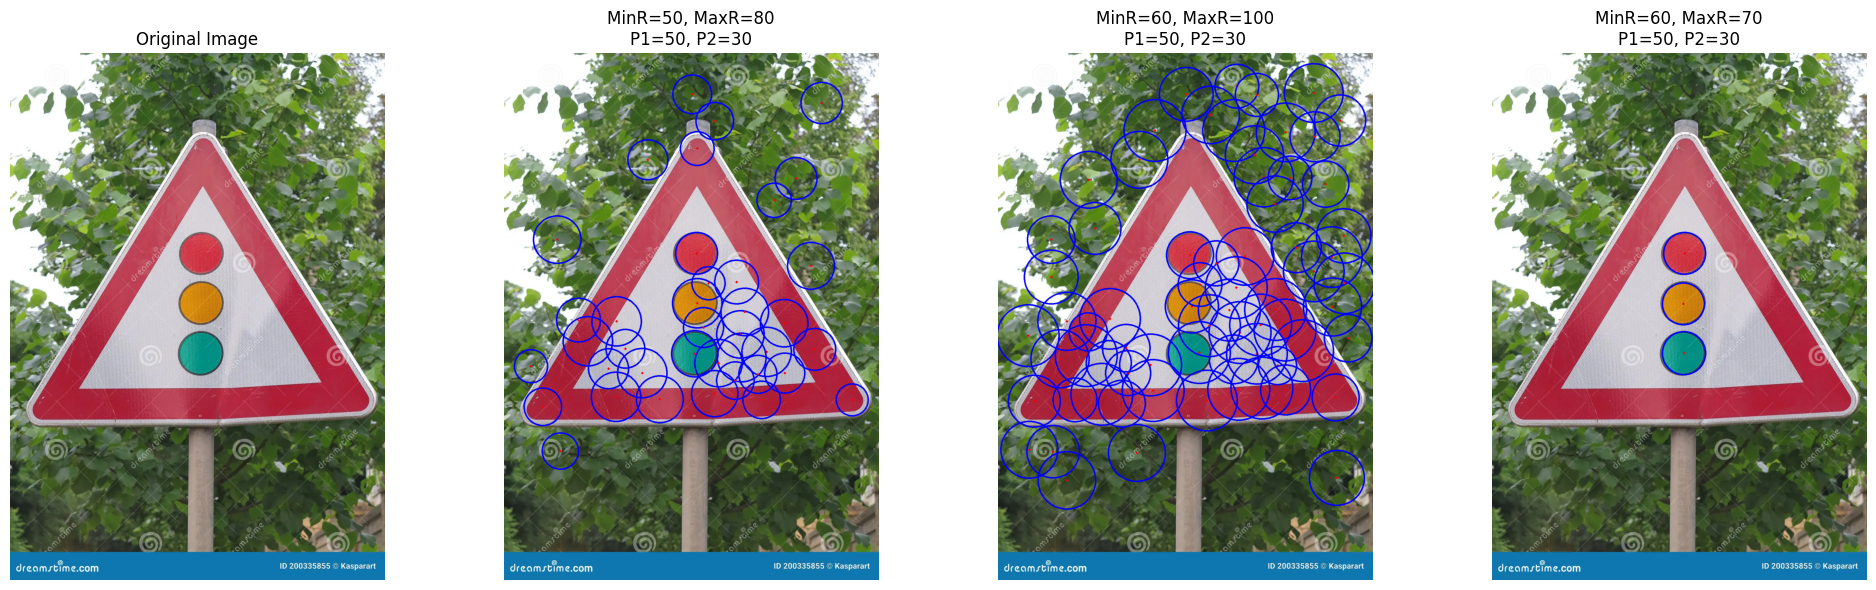

In [97]:
# Define experimental parameters
experiments = [
    {"min_radius": 50, "max_radius": 80, "param1": 50, "param2": 30},
    {"min_radius": 60, "max_radius": 100, "param1": 50, "param2": 30},
    {"min_radius": 60, "max_radius": 70, "param1": 50, "param2": 30},

]

# Original Image
original_img = cv2.imread(input_image_path)
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Perform experiments
fig, axs = plt.subplots(1, len(experiments) + 1, figsize=(20, 6))
axs[0].imshow(original_img_rgb)
axs[0].set_title("Original Image")
axs[0].axis("off")

for idx, params in enumerate(experiments):
    # Run detection with current parameters
    result_img = detect_circles(
        input_image_path,
        min_radius=params["min_radius"],
        max_radius=params["max_radius"],
        param1=params["param1"],
        param2=params["param2"],
    )
    # Convert result to RGB for plotting
    result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    # Plot results
    axs[idx + 1].imshow(result_img_rgb)
    axs[idx + 1].set_title(f"MinR={params['min_radius']}, MaxR={params['max_radius']}\nP1={params['param1']}, P2={params['param2']}")
    axs[idx + 1].axis("off")

plt.tight_layout()
plt.show()


# Results of Circle Detection Experiments

### Experiment 1
- **Parameters**: `min_radius=50`, `max_radius=80`, `param1=50`, `param2=30`
- **Observations**: 
  - Detects **smaller circles**, including noise or irrelevant features.
  - **Issue**: Some extraneous detections from artifacts or background elements.

---

### Experiment 2
- **Parameters**: `min_radius=60`, `max_radius=100`, `param1=50`, `param2=30`
- **Observations**:
  - Detects **larger circles**, possibly including traffic light boundaries.
  - **Issue**: Misses smaller and medium-sized circles.

---

### Experiment 3
- **Parameters**: `min_radius=60`, `max_radius=70`, `param1=50`, `param2=30`
- **Observations**:
  - Provides the **best balance**, accurately capturing medium-sized circles (traffic lights).
  - Reduces noise and avoids irrelevant detections.
  - **Improvement**: Strikes a balance between sensitivity and precision.

---

### Improvements Observed
1. **Radius Range (`min_radius`, `max_radius`)**:
   - Narrowing the range improved focus on relevant circles and reduced false positives.
2. **Threshold Parameters (`param1`, `param2`)**:
   - While constant in these experiments, tuning these values can further enhance edge sensitivity and gradient detection.

---

### Conclusion
- **Best Configuration**: `min_radius=60`, `max_radius=70`, `param1=50`, `param2=30`
- **Reason**: Captures medium-sized circles (traffic lights) accurately with minimal noise, making it the most effective for this specific image.


## 4

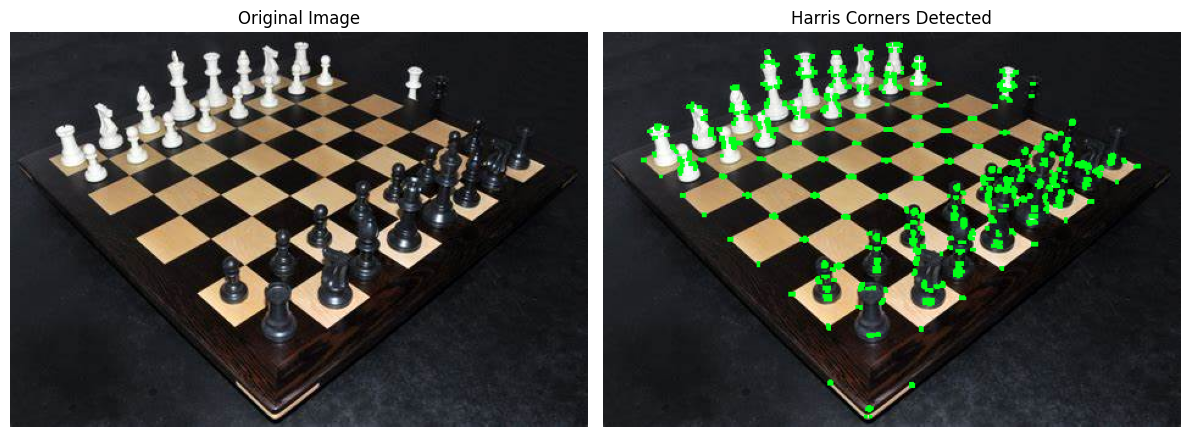

In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def harris_corner_detection(image_path, block_size=2, ksize=3, k=0.04, threshold=0.01):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at {image_path} not found.")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    
    harris_response = cv2.cornerHarris(gray, block_size, ksize, k)
    harris_response = cv2.dilate(harris_response, None)
    
    result_img = img.copy()
    result_img[harris_response > threshold * harris_response.max()] = [25, 255, 2]
    
    return result_img

# Set image path
input_image_path = './../images/4.png'

# Apply the Harris Corner Detection function
corners_marked_image = harris_corner_detection(input_image_path)

# Display the original and processed images
original_image = cv2.imread(input_image_path)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(122)
plt.title("Harris Corners Detected")
plt.imshow(cv2.cvtColor(corners_marked_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


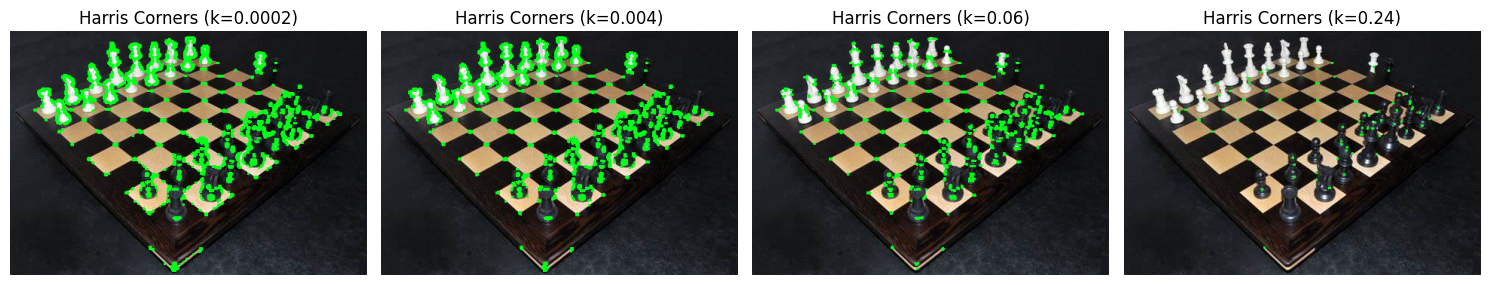

In [125]:
# Image path
image_path = './../images/4.png'

# Different k values to test sensitivity
k_values = [0.0002, 0.004, 0.06, .24]

plt.figure(figsize=(15, 5))

for i, k in enumerate(k_values):
    corners_marked_image = harris_corner_detection(image_path, k=k)
    
    plt.subplot(1, len(k_values), i + 1)
    plt.title(f"Harris Corners (k={k})")
    plt.imshow(cv2.cvtColor(corners_marked_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

plt.tight_layout()
plt.show()



### Effect of Varying the Sensitivity Parameter (k) in Harris Corner Detection

- **Lower k values (e.g., 0.0002)**:
  - The algorithm is more sensitive and detects more corners, including weaker ones.
  - Results in more green dots marking detected corners.

- **Moderate k values (e.g., 0.004, 0.06)**:
  - The algorithm becomes less sensitive, detecting only the most distinct corners.
  - Results in a sparser distribution of detected corners.

- **Higher k values (e.g., 0.24)**:
  - The algorithm becomes very selective, marking only the most pronounced corners.
  - Results in the fewest green dots, focusing on the most reliable features.

- **Conclusion**:
  - **Lower k**: Best for detecting more corners, even weaker ones.
  - **Higher k**: Best for detecting only the most prominent corners.


## Question 5

### Hough Transform: Line vs Circle Detection

The Hough Transform differs in detecting lines versus circles primarily in the parameter space and computational complexity:

- **Parameter Space**:
  - **Line Detection**: Uses a 2D parameter space in polar coordinates \((\rho, \theta)\), where \(\rho\) is the perpendicular distance from the origin to the line, and \(\theta\) is the angle of the line.
  - **Circle Detection**: Uses a 3D parameter space \((a, b, r)\), where \((a, b)\) are the coordinates of the center of the circle, and \(r\) is the radius.

- **Computational Complexity**:
  - **Line Detection**: Computational complexity is lower as it involves searching through a 2D space, making it faster and less memory-intensive.
  - **Circle Detection**: Requires searching a 3D space due to the additional radius parameter, making it more computationally expensive and memory-intensive. Optimizations like fixing the radius or using gradient information can reduce complexity.

In conclusion, **line detection** is simpler, faster, and requires less memory, whereas **circle detection** is more complex, slower, and consumes more resources due to the extra parameter space.
